# Credit Card Approval Using Machine Learning

In [106]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import missingno as mso
import seaborn as sns
import warnings
import pycaret
import math

import pycaret.classification 

# --- Libraries Settings ---
#warnings.filterwarnings('ignore')
#plt.rcParams['figure.dpi'] = 100

In [122]:
cca =  pd.read_csv('credit_card_approval.csv')
# rough years of employment
cca.DAYS_EMPLOYED = abs(cca.DAYS_EMPLOYED) // 365
# finding out each customers age
cca.DAYS_BIRTH =  abs(cca.DAYS_BIRTH) // 365  
cca.AMT_INCOME_TOTAL = pd.to_numeric(cca.AMT_INCOME_TOTAL)
# dropping unneccessary attributes
cca = cca.drop(["BEGIN_MONTHS", "FLAG_MOBIL"], axis=1)



cca.rename(columns = {'CODE_GENDER':'gender', 
                      'DAYS_BIRTH': 'age',
                      'DAYS_EMPLOYED': 'working_years',
                      'FLAG_OWN_CAR':'owning_car',
                      'FLAG_OWN_REALTY': 'owning_property',
                      'CNT_CHILDREN': 'children_amt',
                      'AMT_INCOME_TOTAL': 'anual_income',
                      'NAME_EDUCATION_TYPE': 'education_level',
                      'NAME_FAMILY_STATUS': 'marital_status',
                      'NAME_HOUSING_TYPE': 'way_of_living',
                      'FLAG_WORK_PHONE': 'owning_work_phone',
                      'FLAG_EMAIL': 'owning_email',
                      'FLAG_PHONE': 'owning_phone',
                      'STATUS': 'payment_status',
                      'TARGET': 'risk_user',
                      'JOB': 'job',
                      'ID': 'applicant_ID'
                      }, inplace = True)


cca["owning_car"].replace({'Y' : '1', 'N': '0'}, inplace= True)
cca["risk_user"].replace({1: 'Y', 0: 'N' }, inplace= True)
cca["owning_property"].replace({'Y' : '1', 'N': '0'}, inplace= True)
cca["payment_status"].replace({'0' : '0-29 d overdue', 
                               '1': '30-29 d overdue', 
                               '2': '60-89 d overdue', 
                               '3': '90-119 d overdue', 
                               '4': '120-149 d overdue', 
                               '5': 'bad debts', 
                               'C': 'paid', 
                               'X': 'no loan'}, inplace= True)
cca.sample(10)

,applicant_ID,gender,owning_car,owning_property,children_amt,anual_income,education_level,marital_status,way_of_living,age,working_years,owning_work_phone,owning_phone,owning_email,job,payment_status,risk_user
191935,5099809,M,1,1,1 children,337500.0,Higher education,Married,House / apartment,31,8,0,0,0,Managers,paid,N
527723,5050972,F,0,0,1 children,112500.0,Secondary / secondary special,Single / not married,House / apartment,43,20,0,0,0,Core staff,0-29 d overdue,N
7280,5056031,F,0,0,No children,112500.0,Secondary / secondary special,Civil marriage,House / apartment,55,8,0,0,0,Sales staff,paid,N
462465,5061794,M,0,1,No children,112500.0,Secondary / secondary special,Single / not married,House / apartment,29,5,0,0,1,Security staff,no loan,N
10993,5045468,F,0,1,No children,315000.0,Higher education,Married,House / apartment,37,0,0,0,1,Accountants,paid,N
32675,5117793,F,1,0,2+ children,162000.0,Incomplete higher,Married,House / apartment,26,2,1,1,0,Core staff,0-29 d overdue,N
187309,5117469,M,0,0,1 children,202500.0,Higher education,Married,House / apartment,35,3,1,0,0,Core staff,no loan,N
410542,5106092,M,0,1,No children,225000.0,Secondary / secondary special,Single / not married,House / apartment,43,3,0,1,0,Managers,0-29 d overdue,N
83858,5033641,F,0,1,1 children,405000.0,Higher education,Widow,House / apartment,36,5,1,0,0,Accountants,paid,N
382080,5143101,F,0,0,No children,112500.0,Secondary / secondary special,Married,House / apartment,27,0,1,0,0,Laborers,0-29 d overdue,N


In [123]:
print(cca.dtypes)

columns = []
for n in cca.columns:
    columns.append(n)

for n in columns:  
    print(n)
    print(cca[n].unique())
    for i in cca[n].isna():
        if i == True:
            print("AHAAAA")
    print('\n \n')
    
print(cca.isnull().sum())

applicant_ID           int64
gender                object
owning_car            object
owning_property       object
children_amt          object
anual_income         float64
education_level       object
marital_status        object
way_of_living         object
age                    int64
working_years          int64
owning_work_phone      int64
owning_phone           int64
owning_email           int64
job                   object
payment_status        object
risk_user             object
dtype: object
applicant_ID
[5065438 5142753 5111146 ... 5090938 5116980 5045855]

 

gender
['F' 'M']

 

owning_car
['1' '0']

 

owning_property
['0' '1']

 

children_amt
['2+ children' 'No children' '1 children']

 

anual_income
[ 270000.    81000.   112500.   139500.   144000.   180000.   405000.
  135000.    99000.   103500.   225000.   171000.   202500.    67500.
  121500.   560250.    74250.    90000.   324000.   391500.   292500.
  229500.   157500.    94500.   148500.   450000.    45000.   3

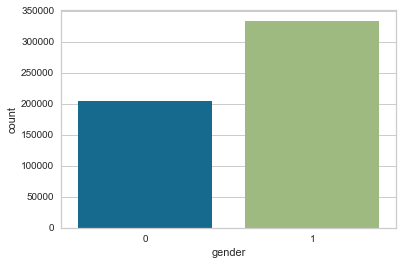

In [73]:
gender_plot = sns.countplot(x='gender',data=cca)


In [127]:
stp = pycaret.classification.setup(data = cca, target = 'risk_user', train_size = 0.8,
            categorical_features = ['gender','owning_car','children_amt', 'owning_property', 'education_level',
                                    'marital_status', 'way_of_living','owning_work_phone', 
                                    'owning_phone','owning_email','job', 'payment_status'], 
            ignore_features = ['applicant_ID'], fix_imbalance = True)

,Description,Value
0,Session id,7564
1,Target,risk_user
2,Target type,Binary
3,Target mapping,"N: 0, Y: 1"
4,Original data shape,"(537667, 16)"
5,Transformed data shape,"(964660, 26)"
6,Transformed train set shape,"(857126, 26)"
7,Transformed test set shape,"(107534, 26)"
8,Ignore features,1
9,Ordinal features,6


In [128]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,14.4870
ridge,Ridge Classifier,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,14.7350
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,38.8950
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,14.8770
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,63.0940
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,35.5120
xgboost,Extreme Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,26.9840
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,14.6890
knn,K Neighbors Classifier,0.9997,0.9729,0.9389,0.9762,0.9571,0.9569,0.9571,199.2070
qda,Quadratic Discriminant Analysis,0.9963,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,15.1430


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [8]:
# --- Setting Up PyCaret ---
#stp = setup(data = cca, target = '', train_size = 0.7)
#best_model = compare_models()
#best_model

,Description,Value
0,Session id,3720
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(537667, 19)"
4,Transformed data shape,"(537667, 29)"
5,Transformed train set shape,"(376366, 29)"
6,Transformed test set shape,"(161301, 29)"
7,Ordinal features,3
8,Numeric features,9
9,Categorical features,9


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,8.2520
ridge,Ridge Classifier,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,8.2710
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,15.9000
qda,Quadratic Discriminant Analysis,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,9.0920
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,9.0560
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,21.7970
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,16.4090
xgboost,Extreme Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,15.5730
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,9.6200
knn,K Neighbors Classifier,0.9974,0.9198,0.4596,0.7289,0.5631,0.5619,0.5773,74.8760


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=3720, splitter='best')